In [1]:
from transformers import ViTFeatureExtractor, TFViTMAEForPreTraining
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
from PIL import Image

c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.config.list_physical_devices('GPU')

tf.keras.backend.clear_session()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
classification_train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/train",
    image_size=(224,224),
    batch_size=64,
    label_mode="int",
    color_mode="rgb",
    shuffle=True
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)

classification_val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/val",
    image_size=(224,224),
    batch_size=64,
    label_mode="int",
    color_mode="rgb",
    shuffle=False
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)

classification_test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/test",
    image_size=(224,224),
    batch_size=64,
    label_mode="int",
    color_mode="rgb",
    shuffle=False
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(tf.data.AUTOTUNE)

feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")

def preprocess_batch(images, labels):
    def _preprocess(images_np):
        # De [0,1] a [0,255] y a uint8
        images_np = (images_np * 255.0).astype(np.uint8)
        # Preprocesa todo el batch
        processed = feature_extractor(images=list(images_np), return_tensors="np")
        # Retorna (batch_size, 3, 224, 224)
        return processed["pixel_values"].astype(np.float32)

    images = tf.numpy_function(_preprocess, [images], tf.float32)
    images.set_shape([None, 3, 224, 224])  # None = batch size variable
    return images, labels

final_train_dataset = classification_train_dataset.map(
    preprocess_batch,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)


final_test_dataset = classification_test_dataset.map(
    preprocess_batch,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

final_val_dataset = classification_val_dataset.map(
    preprocess_batch,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

Found 21000 files belonging to 30 classes.
Found 3000 files belonging to 30 classes.
Found 6000 files belonging to 30 classes.


c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [6]:

# 1️⃣ Carga el modelo ViT-MAE preentrenado (solo queremos el encoder)
mae_model = TFViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
vit_encoder = mae_model.vit

# 2️⃣ Congela el encoder (opcional: lo puedes descongelar más adelante para fine-tuning)
vit_encoder.trainable = True

# 3️⃣ Define el modelo Keras
inputs = keras.Input(shape=(3, 224, 224))
x = vit_encoder(pixel_values=inputs, training=False)[0]  # [0]: el output del encoder

cls_token_output = x[:, 0, :]

# --- INICIO DE LA NUEVA CABEZA ROBUSTA Y REGULARIZADA ---

# Capa de normalización inicial para estabilizar la entrada al head
x = layers.LayerNormalization()(cls_token_output)

# Primera capa Dense con regularización L2 y Batch Normalization
x = layers.Dense(1024,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x) # Normalización de lotes para estabilidad
x = layers.Dropout(0.3)(x) # Dropout para regularización

# Segunda capa Dense con regularización L2 y Batch Normalization
x = layers.Dense(512,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x) # Normalización de lotes para estabilidad
x = layers.Dropout(0.3)(x) # Dropout para regularización


outputs = layers.Dense(30, activation='softmax')(x)  # 30 clases

model = keras.Model(inputs, outputs)

# 4️⃣ Compila el modelo

model.summary()

All PyTorch model weights were used when initializing TFViTMAEForPreTraining.

All the weights of TFViTMAEForPreTraining were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTMAEForPreTraining for predictions without further training.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 224, 224)]     0         
                                                                 
 vit (TFViTMAEMainLayer)     TFViTMAEModelOutput(last  85798656  
                             _hidden_state=(None, 50,            
                              768),                              
                              mask=(None, 196),                  
                              ids_restore=(None, 196)            
                             , hidden_states=None, at            
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem_1   (None, 768)              0         
 (SlicingOpLambda)                                               
                                                           

In [7]:
for images, labels in final_train_dataset.take(1):
    print("Shape de las imágenes en el batch:", images.shape)
    print("Shape de las etiquetas:", labels.shape)

Shape de las imágenes en el batch: (64, 3, 224, 224)
Shape de las etiquetas: (64,)


In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10 , restore_best_weights=True, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath='best_modelV3.h5', save_best_only=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose=1,factor=0.5),
]

history = model.fit(
    final_train_dataset,
    validation_data=final_test_dataset,
    epochs=50,
    callbacks=callbacks,
    verbose=1

)
#save
model.save("best_modelV3.h5")

Epoch 1/50
329/329 [==============================] - 126s 342ms/step - loss: 3.0864 - accuracy: 0.5383 - val_loss: 2.4432 - val_accuracy: 0.6628 - lr: 1.0000e-04
Epoch 2/50
329/329 [==============================] - 107s 322ms/step - loss: 2.1317 - accuracy: 0.7457 - val_loss: 2.0497 - val_accuracy: 0.7712 - lr: 1.0000e-04
Epoch 3/50
329/329 [==============================] - 106s 322ms/step - loss: 1.8213 - accuracy: 0.8099 - val_loss: 1.8275 - val_accuracy: 0.8085 - lr: 1.0000e-04
Epoch 4/50
329/329 [==============================] - 104s 315ms/step - loss: 1.6368 - accuracy: 0.8447 - val_loss: 1.8678 - val_accuracy: 0.7928 - lr: 1.0000e-04
Epoch 5/50
329/329 [==============================] - 107s 322ms/step - loss: 1.4937 - accuracy: 0.8667 - val_loss: 1.5769 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 6/50
329/329 [==============================] - 107s 322ms/step - loss: 1.3659 - accuracy: 0.8921 - val_loss: 1.5570 - val_accuracy: 0.8450 - lr: 1.0000e-04
Epoch 7/50
329/329 [==

<Figure size 1200x1200 with 0 Axes>

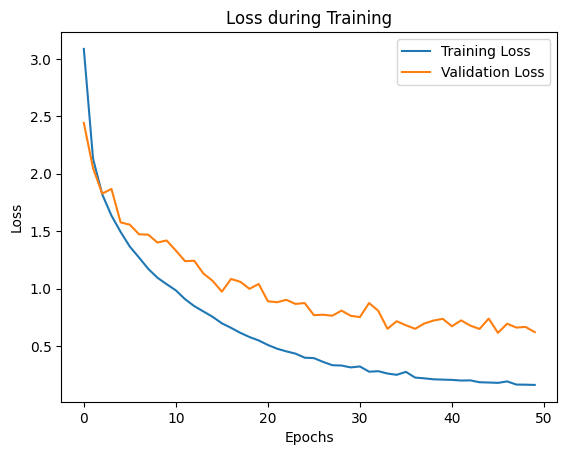

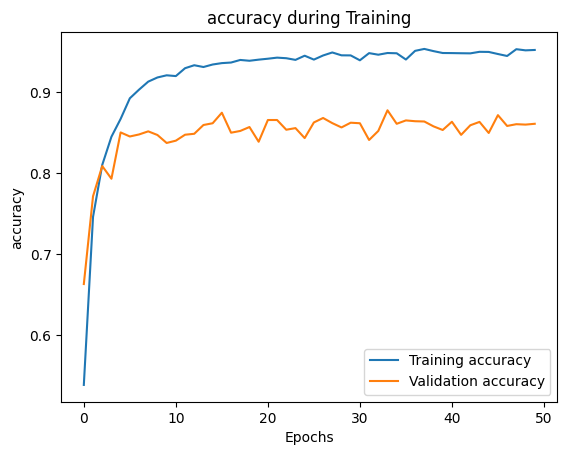

In [8]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    plt.figure(figsize=(12, 12))
    
    # Pérdida
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('accuracy during Training')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()


# Llamar a la función para graficar el progreso del entrenamiento
plot_training_history(history)

2/2 [==============================] - 2s 117ms/step
Accuracy de validación: 0.87


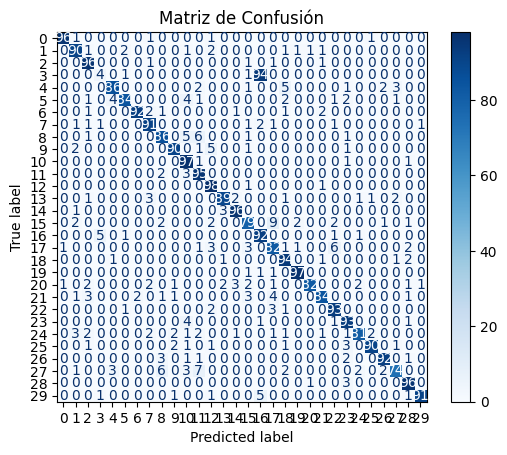

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in final_val_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
    
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy de validación: {accuracy:.2f}")
# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(30))  # Ajusta el rango según tus clases
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
history.history['accuracy']

NameError: name 'history' is not defined